In [1]:
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import block_diag

## Circuit

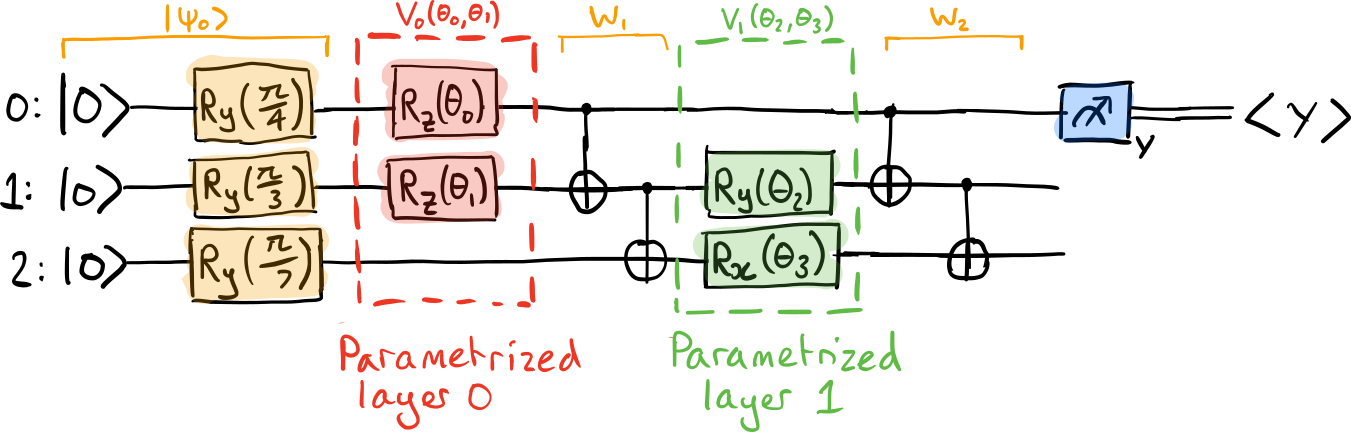

In [2]:
dev = qml.device("lightning.qubit", wires=3)


@qml.qnode(dev, interface="autograd")
def circuit(params):
    # |psi_0>: state preparation
    qml.RY(np.pi / 4, wires=0)
    qml.RY(np.pi / 3, wires=1)
    qml.RY(np.pi / 7, wires=2)

    # V0(theta0, theta1): Parametrized layer 0
    qml.RZ(params[0], wires=0)
    qml.RZ(params[1], wires=1)

    # W1: non-parametrized gates
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])

    # V_1(theta2, theta3): Parametrized layer 1
    qml.RY(params[2], wires=1)
    qml.RX(params[3], wires=2)

    # W2: non-parametrized gates
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])

    return qml.expval(qml.PauliY(0))


params = np.array([0.432, -0.123, 0.543, 0.233])

## The Fubini-Study matrix

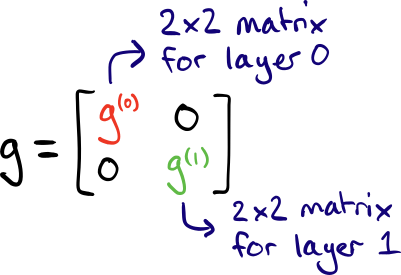

### $g^{(0)}$ calculation

- To compute the first block-diagonal $g^{(0)}$, we create subcircuits consisting of all gates prior to the layer, and observables corresponding to the generators of the gates in the layer.

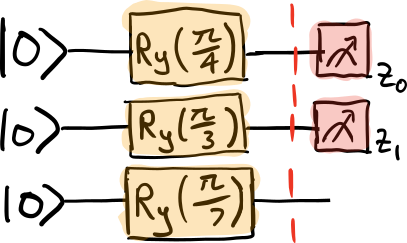

Then the matrix is,
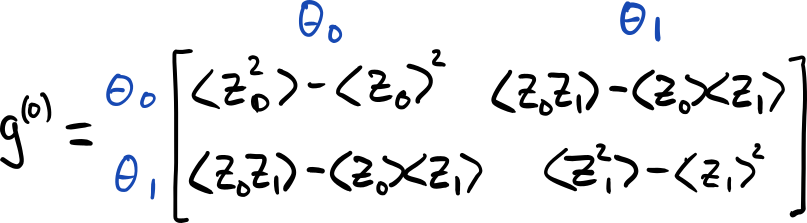

In [3]:
g0 = np.zeros([2, 2])


def layer0_subcircuit(params):
    """This function contains all gates that
    precede parametrized layer 0"""
    qml.RY(np.pi / 4, wires=0)
    qml.RY(np.pi / 3, wires=1)
    qml.RY(np.pi / 7, wires=2)
    

@qml.qnode(dev, interface="autograd")
def layer0_diag(params):
    layer0_subcircuit(params)
    return qml.var(qml.PauliZ(0)), qml.var(qml.PauliZ(1))


# calculate the diagonal terms
varK0, varK1 = layer0_diag(params)
g0[0, 0] = varK0 / 4
g0[1, 1] = varK1 / 4

@qml.qnode(dev, interface="autograd")
def layer0_off_diag_single(params):
    layer0_subcircuit(params)
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))


@qml.qnode(dev, interface="autograd")
def layer0_off_diag_double(params):
    layer0_subcircuit(params)
    ZZ = np.kron(np.diag([1, -1]), np.diag([1, -1]))
    return qml.expval(qml.Hermitian(ZZ, wires=[0, 1]))


# calculate the off-diagonal terms
exK0, exK1 = layer0_off_diag_single(params)
exK0K1 = layer0_off_diag_double(params)

g0[0, 1] = (exK0K1 - exK0 * exK1) / 4
g0[1, 0] = (exK0K1 - exK0 * exK1) / 4

# $g^{(1)}$ calculation

- We can repeat the above process to compute $g^{(1)}$. The subcircuit required is given by

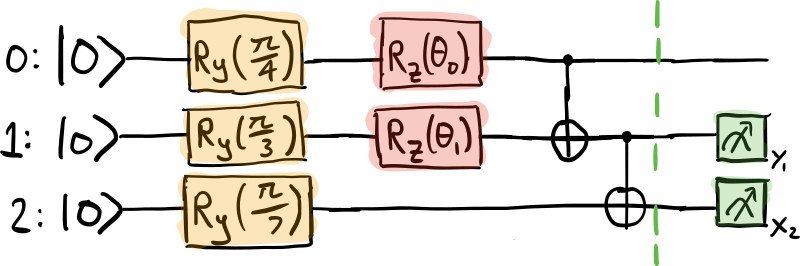

Then the matrix is,

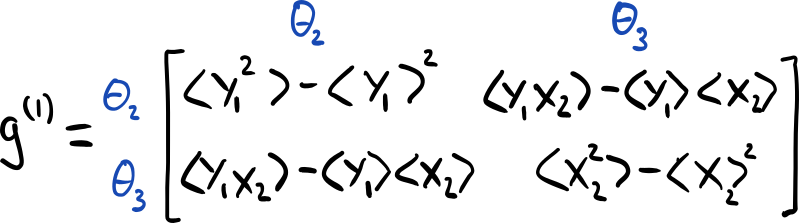

In [4]:
g1 = np.zeros([2, 2])


def layer1_subcircuit(params):
    """This function contains all gates that
    precede parametrized layer 1"""
    # |psi_0>: state preparation
    qml.RY(np.pi / 4, wires=0)
    qml.RY(np.pi / 3, wires=1)
    qml.RY(np.pi / 7, wires=2)

    # V0(theta0, theta1): Parametrized layer 0
    qml.RZ(params[0], wires=0)
    qml.RZ(params[1], wires=1)

    # W1: non-parametrized gates
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])

@qml.qnode(dev, interface="autograd")
def layer1_diag(params):
    layer1_subcircuit(params)
    return qml.var(qml.PauliY(1)), qml.var(qml.PauliX(2))

varK0, varK1 = layer1_diag(params)
g1[0, 0] = varK0 / 4
g1[1, 1] = varK1 / 4

@qml.qnode(dev, interface="autograd")
def layer1_off_diag_single(params):
    layer1_subcircuit(params)
    return qml.expval(qml.PauliY(1)), qml.expval(qml.PauliX(2))


@qml.qnode(dev, interface="autograd")
def layer1_off_diag_double(params):
    layer1_subcircuit(params)
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    YX = np.kron(Y, X)
    return qml.expval(qml.Hermitian(YX, wires=[1, 2]))


# calculate the off-diagonal terms
exK0, exK1 = layer1_off_diag_single(params)
exK0K1 = layer1_off_diag_double(params)

g1[0, 1] = (exK0K1 - exK0 * exK1) / 4
g1[1, 0] = g1[0, 1]

- Putting this altogether, the block-diagonal approximation to the Fubini-Study metric tensor for this variational quantum circuit is

In [5]:
g = block_diag(g0, g1)
print(np.round(g, 8))

[[ 0.125      -0.          0.          0.        ]
 [-0.          0.1875      0.          0.        ]
 [ 0.          0.          0.24973433 -0.01524701]
 [ 0.          0.         -0.01524701  0.20293623]]


- PennyLane contains a built-in function for computing the Fubini-Study metric tensor, `metric_tensor()`, which we can use to verify this result.

In [6]:
print(np.round(qml.metric_tensor(circuit, approx="block-diag")(params), 8))

[[ 0.125       0.          0.          0.        ]
 [ 0.          0.1875      0.          0.        ]
 [ 0.          0.          0.24973433 -0.01524701]
 [ 0.          0.         -0.01524701  0.20293623]]


- Note that the `metric_tensor()` function also supports computing the diagonal approximation to the metric tensor.

In [7]:
print(qml.metric_tensor(circuit, approx='diag')(params))

[[0.125      0.         0.         0.        ]
 [0.         0.1875     0.         0.        ]
 [0.         0.         0.24973433 0.        ]
 [0.         0.         0.         0.20293623]]


## Application of QNGD algorithm to the circuit
- PennyLane provides an implementation of the quantum natural gradient optimizer, `QNGOptimizer`. Let’s compare the optimization convergence of the QNG Optimizer and the `GradientDescentOptimizer` for the simple variational circuit above.

C:\Users\HARSH\AppData\Local\Temp\ipykernel_13884\1820457536.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


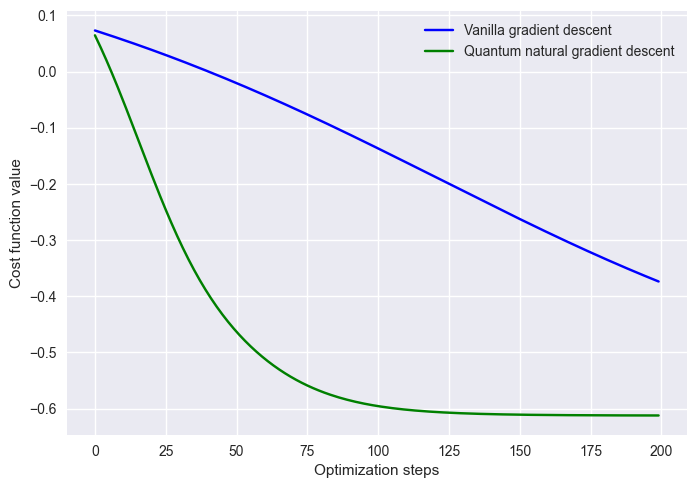

In [8]:
steps = 200
init_params = np.array([0.432, -0.123, 0.543, 0.233], requires_grad=True)

#---------- Performing vanilla gradiente descent ----------
gd_cost = []
opt = qml.GradientDescentOptimizer(0.01)

theta = init_params
for _ in range(steps):
    theta = opt.step(circuit, theta)
    gd_cost.append(circuit(theta))
    
    
#---------- Performing QNGD ----------
qng_cost = []
opt = qml.QNGOptimizer(0.01)

theta = init_params
for _ in range(steps):
    theta = opt.step(circuit, theta)
    qng_cost.append(circuit(theta))
    
plt.style.use("seaborn")
plt.plot(gd_cost, "b", label="Vanilla gradient descent")
plt.plot(qng_cost, "g", label="Quantum natural gradient descent")

plt.ylabel("Cost function value")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()